In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import warnings
import os
import pickle
from statistics import mean
from tqdm import tqdm
from sklearn.cross_decomposition import PLSRegression
from model_tools import check_csv, make_bool, select_spectra

'''
by Cai Ytsma (cai@caiconsulting.co.uk)
Last updated 14 September 2022

Script to make PLS2 models, where one model predicts multiple y variables. 
If only modelling for one variable, PLS1 regression is included in spectral_regression_modelling.py
'''

#-------------------#
# INPUT INFORMATION #
#-------------------#
# data folder
data_folder = input('Folder path containing data: ')
while not os.path.exists(data_folder):
    print(f'Error: path {data_folder} does not exist\n')
    data_folder = input('Folder path containing data: ')
    
all_files = os.listdir(data_folder)

# spectra
spectra_file = check_csv(input('Spectra filename: '))
while spectra_file not in all_files:
    print(f'Error: file {spectra_file} not in data folder\n')
    spectra_file = check_csv(input('Spectra filename: '))
spectra_path = os.path.join(data_folder, spectra_file)

# metadata
meta_file = check_csv(input('Metadata filename: '))
while meta_file not in all_files:
    print(f'Error: file {meta_file} not in data folder\n')
    meta_file = check_csv(input('Metadata filename: '))
meta_path = os.path.join(data_folder, meta_file)

# folder to export results to
outpath = input('File path to export results: ')
while not os.path.exists(outpath):
    print(f'Error: path {outpath} does not exist\n')
    outpath = input('File path to export results: ')

#----------------#
# PREP PROCEDURE #
#----------------#
# read in data
print('\nLoading data')
spectra = pd.read_csv(spectra_path)
axis = list(spectra['wave'].values)
meta = pd.read_csv(meta_path)

# check has folds column
fold_col = 'Folds'
if fold_col not in meta.columns:
    raise ValueError(f"Metadata must have a universal '{fold_col}' column assigned to split the data for cross-validation")

# check data in same order
check = list(spectra.columns[1:]) == list(meta['pkey'].values)
if not check:
    raise ValueError('Spectra and metadata samples need to be in same order')

# extract variables to be run
var_to_run = [col for col in meta.columns if (col not in ['pkey', 'Sample Name', 'Sample_Name']) and ('Folds' not in col)]
if len(var_to_run) == 1:
    raise ValueError(f'Only one variable, {var_to_run[0]}, is in the metadata. PLS2 requires multiple y variables.')
all_var = ', '.join(var_to_run)
print('Identified variables to be predicted by the model:', all_var, '\nWarning: Samples without compositions for all variables will be dropped')

# remove samples without compositions for all variables
meta = meta.dropna()

# get spectra for those samples
cols = list(meta.pkey)
cols.insert(0,'wave')
spectra = spectra[cols]

Folder path containing data: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_data
Spectra filename: spectra_multi
Metadata filename: meta_multi
File path to export results: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_results

Loading data
Identified variables to be predicted by the model: SiO2, TiO2, Al2O3 


In [2]:
#--------------------#
# FORMAT DATA FOR CV #
#--------------------#
# find minimum number of samples in the folds, in cas max_components greater
n_samples_list = []

## remove test data if using it
#if test_fold:
#    temp_meta = self.meta[self.meta[fold_col] != test_fold].copy()
#else:
#    temp_meta = self.meta.copy()

all_folds = list(meta[fold_col].unique())
if -1 in all_folds:
    all_folds.remove(-1)

data_dict = {}
for fold in all_folds:

    # training data
    train_meta = meta[(meta[fold_col] != fold) &
                      (meta[fold_col] != -1)].reset_index(drop=True)
    X_train = select_spectra(spectra, train_meta.pkey)
    y_train = train_meta[var_to_run].values
    n_samples_list.append(len(y_train))

    # held-out data
    test_meta = meta[meta[fold_col] == fold].reset_index(drop=True)
    X_test = select_spectra(spectra, test_meta.pkey)
    y_test = test_meta[var_to_run].values
    n_samples_list.append(len(y_test))

    # add datasets to dictionary
    data_dict[fold] = {'train_spectra':X_train,
                       'train_metadata':y_train,
                       'test_spectra':X_test,
                       'test_metadata':y_test}

min_samples = min(n_samples_list)

# initialize CV results summary
overall_cv_results = {'average':[]}
for var in var_to_run:
    overall_cv_results[var] = []
all_var = list(overall_cv_results.keys())

In [3]:
# get the RMSE-CV per variable, per model during optimization
def run_CV_PLS2(model):

    # initialize CV results summary
    cv_results = {'average':[]}
    for var in var_to_run:
        cv_results[var] = []
        
    for fold in list(data_dict.keys()):

        # get data
        X_train = data_dict[fold]['train_spectra']
        X_test = data_dict[fold]['test_spectra']
        y_train = data_dict[fold]['train_metadata']
        y_test = data_dict[fold]['test_metadata']

        # run model
        model.fit(X_train, y_train)
        # predictions
        preds = model.predict(X_test)
        pred_df = pd.DataFrame(preds)
        pred_df.columns = [f'pred_{var}' for var in var_to_run]
        # actual values
        actual_df = pd.DataFrame(y_test)
        actual_df.columns = [f'actual_{var}' for var in var_to_run]
        # combine
        pred_true = pred_df.merge(actual_df, left_index=True, right_index=True)
        
        # get individual RMSE-Ps
        indiv_rmseps = []
        for var in var_to_run:
            rmsep = sqrt(mean_squared_error(pred_true[f'actual_{var}'], pred_true[f'pred_{var}']))
            cv_results[var].append(rmsep) # value for this fold
            indiv_rmseps.append(rmsep) # to get average for fold
            
        # calculate overall average for this fold
        avg_rmsep = mean(indiv_rmseps)
        cv_results['average'].append(avg_rmsep)
        
    #then, append means to overall dict
    for var in var_to_run+['average']:
        overall_cv_results[var].append(mean(cv_results[var]))

In [4]:
max_components = 20
component_range = np.arange(start=2, stop=max_components+1, step=1)

for n_components in tqdm(component_range):
    # define model
    run_CV_PLS2(PLSRegression(n_components = n_components, scale=False))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:40<00:00,  5.29s/it]


In [66]:
# cumulate best results per variable
best_results = dict()
for var in all_var:
    results = dict(zip(overall_cv_results[var], component_range))
    min_rmsecv = min(overall_cv_results[var])
    best_component = results[min_rmsecv]
    best_results[var] = [best_component, min_rmsecv]

In [74]:
import matplotlib.ticker as mticker

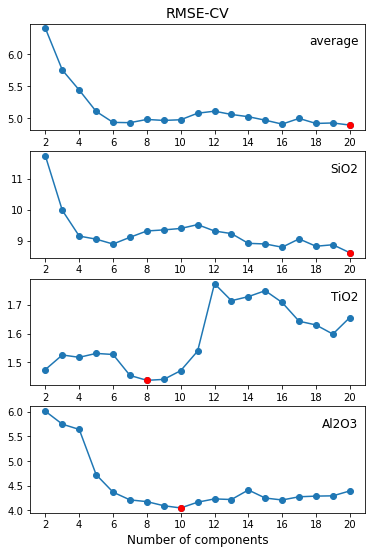

In [78]:
n_var = len(all_var)

fig, axes = plt.subplots(nrows=n_var,
                         figsize=(6,9))
for i in np.arange(n_var):
    
    # get variable name and best results
    var = all_var[i]
    best_component = best_results[var][0]
    best_rmsecv = best_results[var][1]
    
    # PLOT
    # dots
    axes[i].scatter(component_range, overall_cv_results[var])
    # line
    axes[i].plot(component_range, overall_cv_results[var])
    # best point
    axes[i].plot(best_component, best_rmsecv, color='red', marker='o')
    # label
    axes[i].annotate(var, xy=(0.98, 0.8), ha='right', xycoords='axes fraction', fontsize=12)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

axes[0].set_title('RMSE-CV', fontsize=14)
axes[n_var-1].set_xlabel('Number of components', fontsize=12)    
plt.show()

In [84]:
train_meta = meta[(meta[fold_col] != -1) &
                  (~meta[fold_col].isnull())]
y_train = train_meta[var_to_run].values
train_names = train_meta['pkey'].values
X_train = select_spectra(spectra, train_names)

In [89]:
component_to_use=10
all_var = ', '.join(var_to_run)
model = PLSRegression(n_components = component_to_use, scale=False)
model.fit(X_train, y_train)
# export
pickle.dump(model, open(f"{outpath}\\PLS2_model_{all_var.replace(', ','_')}.asc", 'wb'), protocol=0)

In [111]:
coef_df

,wave,SiO2_coeffs,TiO2_coeffs,Al2O3_coeffs
0,intercept,52.288692,0.787680,13.078407
0,245.579788,7.928352,-0.480075,-0.775770
1,245.632355,6.871721,-0.402554,-0.900207
2,245.684921,2.970190,-0.129858,-0.935378
3,245.737472,-0.434826,0.128182,-1.043751
...,...,...,...,...
7681,847.945435,10.149589,-0.697431,-1.108154
7682,848.014587,9.796373,-0.713265,-1.170130
7683,848.08374,10.049057,-0.755826,-1.264199
7684,848.152771,10.251102,-0.787947,-1.332919


In [121]:
spectrum

,wave,Cr_AP15_PDCV_2_1,derivative
0,5909.0,0.002960,NaN
1,5911.5,0.002960,0.000000
2,5914.0,0.002497,-0.000185
3,5916.5,0.002544,0.000019
4,5919.0,0.002658,0.000046
...,...,...,...
444,6195.0,1.003560,0.000530
445,6197.0,1.000000,-0.001780
446,6199.0,0.996970,-0.001515
447,6201.0,0.996282,-0.000344


In [100]:
coef_df

,wave,SiO2_coeffs,TiO2_coeffs,Al2O3_coeffs
0,245.579788,7.928352,-0.480075,-0.775770
1,245.632355,6.871721,-0.402554,-0.900207
2,245.684921,2.970190,-0.129858,-0.935378
3,245.737472,-0.434826,0.128182,-1.043751
4,245.790024,-3.356447,0.340021,-1.198579
...,...,...,...,...
7681,847.945435,10.149589,-0.697431,-1.108154
7682,848.014587,9.796373,-0.713265,-1.170130
7683,848.083740,10.049057,-0.755826,-1.264199
7684,848.152771,10.251102,-0.787947,-1.332919


In [110]:

coef_df

,wave,SiO2_coeffs,TiO2_coeffs,Al2O3_coeffs
0,intercept,52.288692,0.787680,13.078407
0,245.579788,7.928352,-0.480075,-0.775770
1,245.632355,6.871721,-0.402554,-0.900207
2,245.684921,2.970190,-0.129858,-0.935378
3,245.737472,-0.434826,0.128182,-1.043751
...,...,...,...,...
7681,847.945435,10.149589,-0.697431,-1.108154
7682,848.014587,9.796373,-0.713265,-1.170130
7683,848.08374,10.049057,-0.755826,-1.264199
7684,848.152771,10.251102,-0.787947,-1.332919


In [10]:
# select parameters of model with lowest rmsecv
msecv = min(list(cv_dict.keys()))
rmsecv = sqrt(msecv)
component = cv_dict[msecv]
model = PLSRegression(n_components = component, scale=False)
print(f'\n\tLowest RMSE-CV of {round(rmsecv,2)} obtained from {component}-component model')

PLSRegression(n_components=20, scale=False)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
import warnings
import os
import pickle

from model_tools import *

'''
by Cai Ytsma (cai@caiconsulting.co.uk)
Last updated 15 August 2022

Train spectral calibration standards with PLS and/or LASSO modelling. 
Optionally use one fold of standards as test set.

Spectra file column format:
'wave' (wavelength axis), {sample_1} (spectral intensities), {sample_2}, etc.

Metadata file format:
'pkey' (sample names), 'Folds' OR '{variable}_Folds' (folds to split data), {variable} (values to be predicted), etc.

'Folds' will be used as fold column if no {variable}_Folds column is specified.

OUTPUT:
- Model file
    {variable}_{model}_model.asc

- Model-predicted versus true values and XY plots 
    {variable}_{model}_{train/test}_pred_true.csv
    {variable}_{model}_{train/test}_pred_true_plot.jpg
    {variable}_{model}_{train/test}_pred_true_plot.eps

- Model coefficient values and plot over example spectrum
    {variable}_{model}_coefs.csv
    {variable}_{model}_coefs_plot.jpg
    {variable}_{model}_coefs_plot.eps
    
- Overall results
    # train/test, model parameters, RMSEs, R2s
'''

#######################################################
# regression parameters to optionally change

# PLS 
#maximum number of components
max_components = 30

# LASSO, Ridge, ElasticNet, SVR
#number of values to test
num_params = 30

# what degree polynomial for SVR?
poly_deg = 2

#######################################################


# INPUT INFORMATION

# data folder
data_folder = input('Folder path containing data: ')
while not os.path.exists(data_folder):
    print(f'Error: path {data_folder} does not exist\n')
    data_folder = input('Folder path containing data: ')
    
all_files = os.listdir(data_folder)

# spectra
spectra_file = check_csv(input('Spectra filename: '))
while spectra_file not in all_files:
    print(f'Error: file {spectra_file} not in data folder\n')
    spectra_file = check_csv(input('Spectra filename: '))
spectra_path = os.path.join(data_folder, spectra_file)

# metadata
meta_file = check_csv(input('Metadata filename: '))
while meta_file not in all_files:
    print(f'Error: file {meta_file} not in data folder\n')
    meta_file = check_csv(input('Metadata filename: '))
meta_path = os.path.join(data_folder, meta_file)

# folder to export results to
outpath = input('File path to export results: ')
while not os.path.exists(outpath):
    print(f'Error: path {outpath} does not exist\n')
    outpath = input('File path to export results: ')
    
    
# RUN PROCEDURE

# read in data
print('\nLoading data')
spectra = pd.read_csv(spectra_path)
axis = list(spectra['wave'].values)
meta = pd.read_csv(meta_path)

# make class instance for formatting
form = Format(spectra, meta)

# check data in same order
check = list(spectra.columns[1:]) == list(meta['pkey'].values)
if not check:
    raise ValueError('Spectra and metadata samples need to be in same order')
    
# extract variables to be run
var_to_run = [col for col in meta.columns if (col not in ['pkey', 'Sample Name', 'Sample_Name']) and ('Folds' not in col)]
all_var = ', '.join(var_to_run)
print('Identified variable(s) to model:', all_var)

# available regression methods 
method_dict = {
    0:['PLS', 'LASSO', 'Ridge', 'ElasticNet', 'SVR-lin', 'SVR-py', 'PCR'],
    1:['PLS'],
    2:['LASSO'],
    3:['Ridge'],
    4:['ElasticNet'],
    5:['SVR-lin'],
    6:['SVR-py'],
    7:['PCR']
}
all_methods = ', '.join([str(x) for x in method_dict.keys()])
method_prompt = 'Do you want to run [1] PLS, [2] LASSO, [3] Ridge, [4] ElasticNet, [5] SVR-linear, [6] SVR-polynomial, [7] PCR, or [0] all models? '

# check if run same procedure for all var
std_prompt = 'Should all variables follow the same modelling procedure? (set test fold, model type(s)) (y/n): '
standard = False
if len(var_to_run) > 1:
    standard = make_bool(input(std_prompt).lower())
    while standard == 'error':
        print('Error: Input needs to be either y or n')
        standard = make_bool(input(std_prompt).lower())

# if so, get parameters
test_prompt = 'Do you want to use one of the folds as a test set? Otherwise all data used for training (y/n): '
if standard:
    do_test = make_bool(input(test_prompt).lower())
    while do_test == 'error':
        print('Error: Input needs to be either y or n')
        do_test = make_bool(input(test_prompt).lower())
    if do_test:
        test_fold = int(input(f'Which fold should be the test fold? '))
    method_type = int(input(method_prompt))
    while method_type not in method_dict.keys():
        print(f"Error: Input must be one of {all_methods}")
        method_type = int(input(method_prompt))
               
# prep lists for results df
n_train_list = []
rmsecv_list = []
param_list = []
rmsec_list = []
intercept_list = []
r2_train_list = []
adj_r2_train_list = []
n_test_list = []
rmsep_list = []
r2_test_list = []
adj_r2_test_list = []
test_fold_list = []
method_list = []
var_list = []

for var in var_to_run:
    
    print(f'\nRunning for {var}')
    fold_col = form.get_fold_col(var)
    
    # ask for var parameters if not standardized procedure
    if not standard:
        do_test = make_bool(input(test_prompt).lower())
        if do_test:
            test_fold = int(input(f'Which fold should be the test fold? '))

    # get data in the correct format for CV
    if do_test:
        all_folds = ', '.join([str(x) for x in meta[fold_col].unique() if x != -1])
        while test_fold not in meta[fold_col].unique():
            print(f'{test_fold} not in list of available folds: {all_folds}')
            test_fold = int(input(f'Which fold should be the test fold? '))
        data_dict = form.make_data_dict(var, fold_col, test_fold)
    else:
        data_dict = form.make_data_dict(var, fold_col)

    # initiate modelling class with data dictionary
    modelling = Model(data_dict)
    
    if not standard:
        method_type = int(input(method_prompt))
        while method_type not in method_dict.keys():
            print(f"Error: Input must be one of {all_methods}")
            method_type = int(input(method_prompt))

    
    for method in method_dict[method_type]:
        
        # optimize models with CV
        print(f'\nPerforming CV for {method}:')
    
        if method == 'PLS':
            param, rmsecv, model = modelling.run_PLS(max_components)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from {param}-component model')
        
        elif method == 'LASSO':
            param, rmsecv, model = modelling.run_LASSO(num_params)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from model with an alpha of {round(param,5)}')
            
        elif method == 'Ridge':
            param, rmsecv, model = modelling.run_Ridge(num_params)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from model with an alpha of {round(param,5)}')
            
        elif method == 'ElasticNet':
            params, rmsecv, model = modelling.run_ElasticNet(num_params)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from model with an alpha of {round(params[0],5)} and an l1_ratio of {params[1]}')
            param = ', '.join([str(x) for x in params])
            
        elif method == 'SVR-lin':
            param, rmsecv, model = modelling.run_SVR_linear(num_params)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from model with an epsilon of {round(param,5)}')
            
        elif method == 'SVR-py':
            param, rmsecv, model = modelling.run_SVR_poly(num_params, poly_deg)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from model with an epsilon of {round(param,5)}')
            
        elif method == 'PCR':
            param, rmsecv, model = modelling.run_PCR(max_components)
            print(f'\tLowest RMSE-CV of {round(rmsecv,2)} obtained from {param}-component model')

        # get data in format for full model
        print(f'\nTraining model:')
        if do_test:
            train_names, X_train, y_train, test_names, X_test, y_test = form.format_spectra_meta(var, fold_col, test_fold)
        else:
            train_names, X_train, y_train = form.format_spectra_meta(var, fold_col)

        # fit training model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        pickle.dump(model, open(f'{outpath}\\{var}_{method}_model.asc', 'wb'), protocol=0)


Folder path containing data: C:\Users\ytsma22c\Documents\GitHub\misc\auto-modeling scripts\test_data
Spectra filename: train_spectra
Metadata filename: train_meta_stratified
File path to export results: C:\Users\ytsma22c\Documents\GitHub\misc\auto-modeling scripts\test_results

Loading data
Identified variable(s) to model: Al2O3

Running for Al2O3
Do you want to use one of the folds as a test set? Otherwise all data used for training (y/n): y
Which fold should be the test fold? 1
Do you want to run [1] PLS, [2] LASSO, [3] Ridge, [4] ElasticNet, [5] SVR-linear, [6] SVR-polynomial, [7] PCR, or [0] all models? 7

Performing CV for PCR:


component value: 100%|█████████████████████████████████████████████████████████████████| 29/29 [00:16<00:00,  1.74it/s]


	Lowest RMSE-CV of 3.99 obtained from 28-component model

Training model:


In [4]:
            if method == 'SVR-lin':
                coef_list = list(model.coef_[0])
            elif method == 'PCR':
                coef_list = list(model.named_steps['linear'].coef_)
            else:
                coef_list = list(model.coef_)

In [13]:
method_dict = {
    0:['PLS', 'LASSO', 'Ridge', 'ElasticNet', 'SVR-lin', 'SVR-py', 'PCR', 'kernel-PCR'],
    1:['PLS'],
    2:['LASSO'],
    3:['Ridge'],
    4:['ElasticNet'],
    5:['SVR-lin'],
    6:['SVR-py'],
    7:['PCR'],
    8:['kernel-PCR']
}

In [45]:
while True:
    method_type = input(method_prompt)
    method_types = [int(x) for x in re.findall('\d', str(method_type))]

    if set(method_types).issubset(set(method_dict.keys())):
    
        if len(method_types)>1:    
            methods_torun = []
            for m in method_types:
                methods_torun = methods_torun + method_dict[m]
                methods_torun = list(set(methods_torun))

        elif len(method_types) == 1:
            methods_torun = method_dict[method_types[0]]
        
        break
    
    else:    
        print(f"Error: Input must be one of {all_methods}")
        
methods_torun

Do you want to run [1] PLS, [2] LASSO, [3] Ridge, [4] ElasticNet, [5] SVR-linear, [6] SVR-polynomial, [7] PCR, or [0] all models? 8


['kernel-PCR']

In [8]:
method_type = '10,2, 3 10 5,6'
method_types = [int(x) for x in re.findall('\d+', str(method_type))]
method_types

[10, 2, 3, 10, 5, 6]

In [30]:
methods_torun

['LASSO']

In [25]:
[int(x) for x in re.findall('\d', '123')]

[1, 2, 3]

In [24]:
re.findall('\d', '123')

['1', '2', '3']

In [12]:
# PREDICTIONS
train_preds = model.predict(X_train)
train_pred_true = pd.DataFrame({
'pkey' : train_names,
'actual' : y_train.flatten().tolist(),
'pred' : train_preds.flatten().tolist()
})
train_pred_true.to_csv(f'{outpath}\\{var}_{method}_train_pred_true.csv', index=False)

rmsec = sqrt(mean_squared_error(train_pred_true.actual, train_pred_true.pred))
r2_train = model.score(X_train,y_train)
adj_r2_train = 1 - (1-r2_train)*(len(train_pred_true) - 1) / (len(train_pred_true) - (train_pred_true.shape[1] - 1) - 1)

# plot
Plot.pred_true(df = train_pred_true, 
           var = var, 
           method = method, 
           type = 'train', 
           rmse = rmsec, 
           adj_r2 = adj_r2_train, 
           path = outpath)

print(f'\tRMSE-C: {round(rmsec,3)}    R2: {round(r2_train,3)}    Adjusted R2: {round(adj_r2_train,3)}')


	RMSE-C: 2.741    R2: 0.881    Adjusted R2: 0.881


In [ ]:
        # INTERCEPT
        if method == 'PLS':
            intercept = (model._y_mean - np.dot(model._x_mean, model.coef_))[0]
        elif method == 'PCR':
            intercept = model.named_steps['linear'].intercept_
        else:
            intercept = model.intercept_
        
        # COEFFICIENTS
        if method != 'SVR-py':
            
            if method == 'SVR-lin':
                coef_list = list(model.coef_[0])
            elif method == 'PCR':
                coef_list = list(model.named_steps['linear'].coef_)
            else:
                coef_list = list(model.coef_)
            
            coef = pd.DataFrame({
                'wave':axis,
                'coef':coef_list
            })
            if not pd.api.types.is_numeric_dtype(coef['coef']):
                coef['coef'] = [x[0] for x in coef.coef]

            coef.to_csv(f'{outpath}\\{var}_{method}_coefs.csv', index=False)

            # plot
            Plot.coeffs(df = coef,
                        spectrum = X_train[0],
                        var = var,
                        method = method,
                        path = outpath)
        else:
            print(f'{method} does not generate coefficients')
        
        # PREDICTIONS
        train_preds = model.predict(X_train)
        train_pred_true = pd.DataFrame({
            'pkey' : train_names,
            'actual' : y_train.flatten().tolist(),
            'pred' : train_preds.flatten().tolist()
        })
        train_pred_true.to_csv(f'{outpath}\\{var}_{method}_train_pred_true.csv', index=False)

        rmsec = sqrt(mean_squared_error(train_pred_true.actual, train_pred_true.pred))
        r2_train = model.score(X_train,y_train)
        adj_r2_train = 1 - (1-r2_train)*(len(train_pred_true) - 1) / (len(train_pred_true) - (train_pred_true.shape[1] - 1) - 1)
        
        # plot
        Plot.pred_true(df = train_pred_true, 
                       var = var, 
                       method = method, 
                       type = 'train', 
                       rmse = rmsec, 
                       adj_r2 = adj_r2_train, 
                       path = outpath)

        print(f'\tRMSE-C: {round(rmsec,3)}    R2: {round(r2_train,3)}    Adjusted R2: {round(adj_r2_train,3)}')

        # add data to lists
        var_list.append(var)
        n_train_list.append(len(y_train))
        method_list.append(method)
        rmsecv_list.append(rmsecv)
        intercept_list.append(intercept)
        param_list.append(param)
        rmsec_list.append(rmsec)
        r2_train_list.append(r2_train)
        adj_r2_train_list.append(adj_r2_train)

        # optional testing
        if do_test:
            print(f'\nTesting model:')
            # TEST PREDICTIONS
            test_preds = model.predict(X_test)
            test_pred_true = pd.DataFrame({
                'pkey' : test_names,
                'actual' : y_test.flatten().tolist(),
                'pred' : test_preds.flatten().tolist()
            })
            test_pred_true.to_csv(f'{outpath}\\{var}_{method}_test_pred_true.csv', index=False)

            rmsep = sqrt(mean_squared_error(test_pred_true.actual, test_pred_true.pred))
            r2_test = model.score(X_test,y_test)
            adj_r2_test = 1 - (1-r2_test)*(len(test_pred_true) - 1) / (len(test_pred_true) - (test_pred_true.shape[1] - 1) - 1)
            
            # Plot
            Plot.pred_true(df = test_pred_true, 
                           var = var, 
                           method = method, 
                           type = 'test', 
                           rmse = rmsep, 
                           adj_r2 = adj_r2_test, 
                           path = outpath)
            
            print(f'\tRMSE-P: {round(rmsep,3)}    R2: {round(r2_test,3)}    Adjusted R2: {round(adj_r2_test,3)}')

            test_fold_list.append(test_fold)
            n_test_list.append(len(y_test))
            rmsep_list.append(rmsep)
            r2_test_list.append(r2_test)
            adj_r2_test_list.append(adj_r2_test) 
        else:
            test_fold_list.append('NA')
            n_test_list.append('NA')
            rmsep_list.append('NA')
            r2_test_list.append('NA')
            adj_r2_test_list.append('NA')  
    
# output results
if (set(test_fold_list) == {'NA'}) and (set(n_test_list) == {'NA'}) and(set(rmsep_list) == {'NA'}) and(set(r2_test_list) == {'NA'}) and(set(adj_r2_test_list) == {'NA'}):
    results = pd.DataFrame({
        'variable':var_list,
        '# train':n_train_list,
        'model type':method_list,
        'RMSE-CV':rmsecv_list,
        'model parameter':param_list,
        'model intercept':intercept_list,
        'RMSE-C':rmsec_list,
        'R2 train':r2_train_list,
        'adj-R2 train':adj_r2_train_list
    })
    
    results.to_csv(f'{outpath}\\modelling_train_results.csv', index=False)
else:
    results = pd.DataFrame({
        'variable':var_list,
        '# train':n_train_list,
        'model type':method_list,
        'RMSE-CV':rmsecv_list,
        'model parameter':param_list,
        'model intercept':intercept_list,
        'RMSE-C':rmsec_list,
        'R2 train':r2_train_list,
        'adj-R2 train':adj_r2_train_list,
        'test fold':test_fold_list,
        '# test':n_test_list,
        'RMSE-P':rmsep_list,
        'R2 test':r2_test_list,
        'adj-R2 test':adj_r2_test_list
    })

    results.to_csv(f'{outpath}\\modelling_train_test_results.csv', index=False)